### Load all files

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open("experiences.pkl", 'r') as picklefile: 
    experiences = pickle.load(picklefile)
with open("skills.pkl", 'r') as picklefile: 
    skills = pickle.load(picklefile)
with open("education.pkl", 'r') as picklefile: 
    education = pickle.load(picklefile)
with open("exams.pkl", 'r') as picklefile: 
    exams = pickle.load(picklefile)
with open("assignments.pkl", 'r') as picklefile: 
    assignments = pickle.load(picklefile)

### Explore Skills

In [14]:
len(skills["ciphertext"].unique())

19804

In [41]:
skill_count = skills[["skill_name", "ciphertext"]].groupby("skill_name").count().reset_index()
skill_pop_count = skill_count[skill_count["ciphertext"] > 1670]

In [43]:
skill_pop_count = skill_pop_count.sort_values("ciphertext")

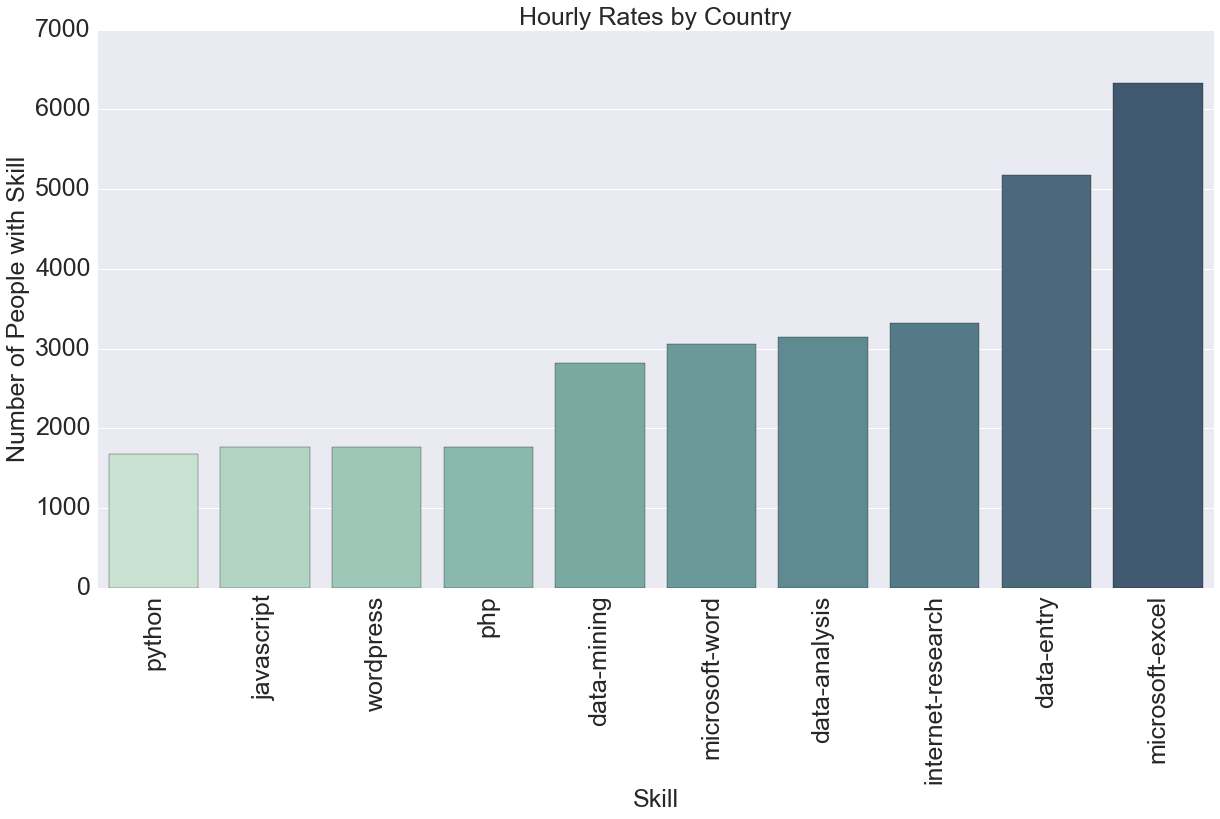

In [67]:
rc={'xtick.labelsize': 25, 'ytick.labelsize': 25, 'axes.labelsize': 25, 'font.size': 25, 'legend.fontsize': 25.0, 'axes.titlesize': 25, "figure.figsize": [20, 10]}
sns.set(rc)
#sns.set_palette(sns.light_palette("green", n_colors = 14))
sns.set_palette(sns.cubehelix_palette(13, start=.1, rot=-.4))
g = sns.barplot(x = "skill_name", y = "ciphertext", data = skill_pop_count)
plt.xticks(rotation=90)
g.set(xlabel = "Skill", ylabel = "Number of People with Skill", title = "Hourly Rates by Country")

In [47]:
# percentage plot
skill_pop_count["percentage"] = skill_pop_count["ciphertext"]/len(skills["ciphertext"].unique()) * 100

In [54]:
skill_pop_count = skill_pop_count.round({"percentage": 2})
skill_pop_count['Percent_format'] = skill_pop_count['percentage'].astype(str) + '%'

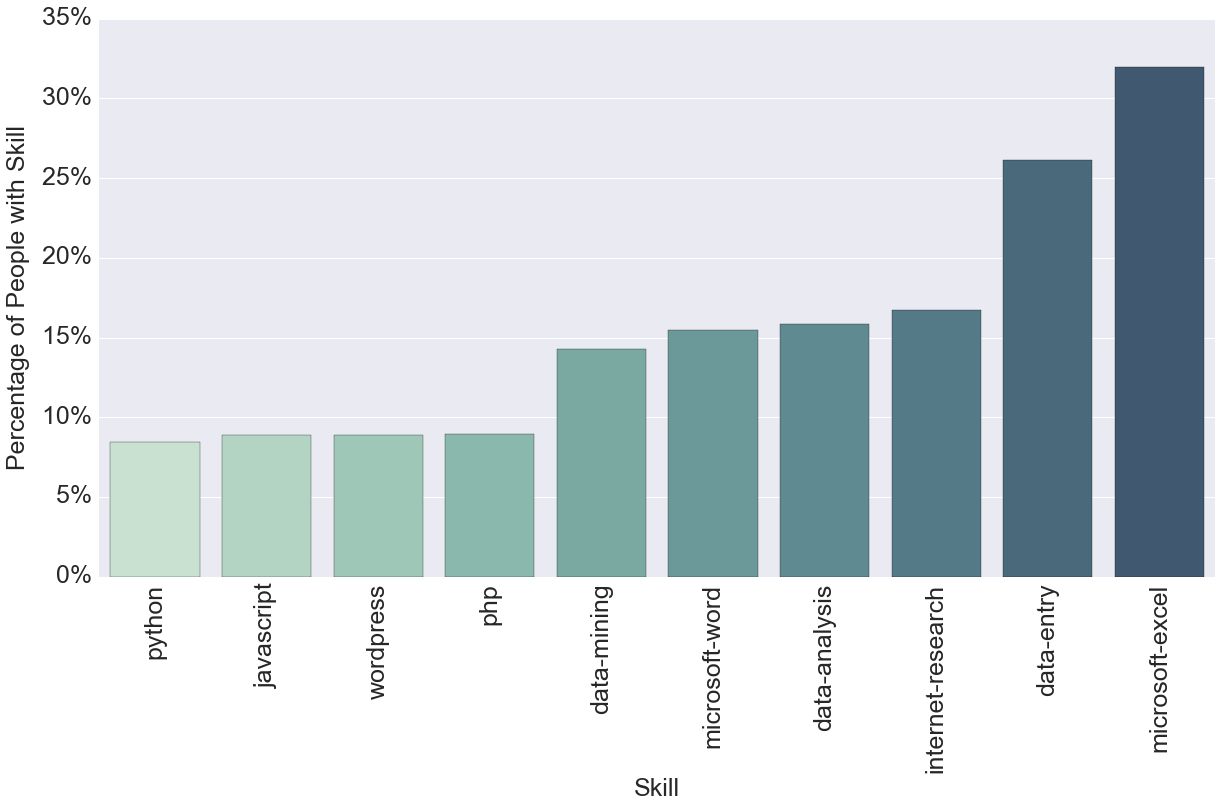

In [69]:
g = sns.barplot(x = "skill_name", y = "percentage", data = skill_pop_count)
plt.xticks(rotation=90)
vals = g.get_yticks()
g.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])
g.set(xlabel = "Skill", ylabel = "Percentage of People with Skill")
plt.savefig("skill_percentage.png", bbox_inches='tight', dpi = 115)

In [78]:
skill_pop_count = skill_pop_count.sort_values("ciphertext", ascending = False)

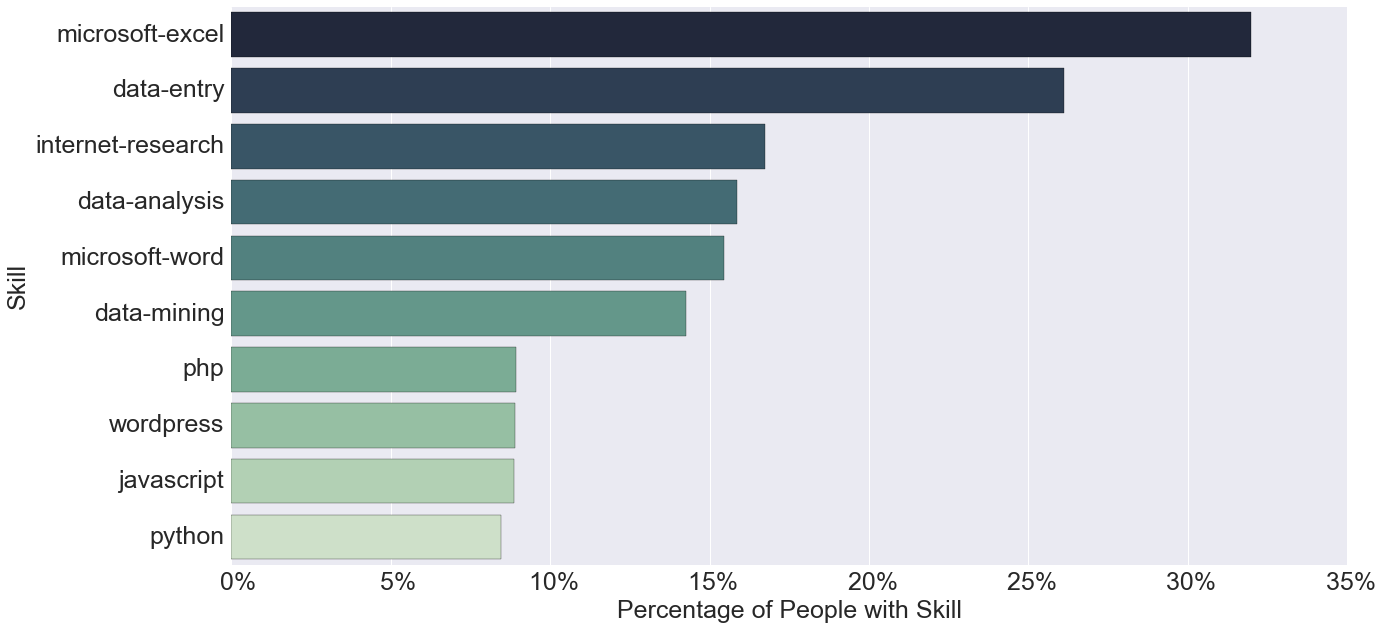

In [90]:
sns.set_palette(sns.cubehelix_palette(10, start=.1, rot = -.5, reverse = True))

g = sns.barplot(y = "skill_name", x = "percentage", data = skill_pop_count)
g.set(xlabel = "Percentage of People with Skill", ylabel = "Skill")
vals = g.get_xticks()
g.set_xticklabels(['{:3.0f}%'.format(x) for x in vals])
plt.savefig("skill_percentage_hor.png", bbox_inches='tight', dpi = 115)

In [20]:
# average number of skills per person
num_skills_pp = skills[["ciphertext", "skill_name"]].groupby("ciphertext").agg('count').reset_index()
print "People have an average number of %d" %num_skills_pp["skill_name"].mean() + " skills"

People have an average number of 7 skills


In [14]:
print "There are %d" %len(skills["skill_name"].unique()) + " unique skill names"

There are 2326 unique skill names


In [40]:
skills_by_num_people = skills[["ciphertext", "skill_name"]].groupby("skill_name").agg('count').reset_index()
skills_by_num_people.columns = ["skill_name", "count"]
skills_by_num_people = skills_by_num_people.sort_values("count", ascending = False)

In [39]:
# The most common skills
skills_by_num_people.head(20)

,skill_name,count
1213,microsoft-excel,6336
520,data-entry,5173
960,internet-research,3316
514,data-analysis,3143
1252,microsoft-word,3060
524,data-mining,2823
1486,php,1771
2265,wordpress,1761
1008,javascript,1759
1574,python,1676


### Explore Education

In [42]:
education.head()

,ed_to,ed_area,ed_school,ed_comment,ed_from,ed_degree,ciphertext
5,01/2014,Financial Methods and Quantitative Analysis,University of Toronto,,01/2014,,~01d3ad50155896e4ae
6,01/2013,Master of Business Economics,University College Cork,,01/2011,,~01d3ad50155896e4ae
7,01/2012,Financial Management,Cornell University,,01/2012,,~01d3ad50155896e4ae
8,01/2011,Economics and Chinese Studies,University College Cork,,01/2007,Bachelor of Arts (B.A.),~01d3ad50155896e4ae
9,01/2010,Mandarin Chinese,Shanghai University,,01/2009,,~01d3ad50155896e4ae


In [64]:
per_indicating_degree = float(len(education[education["ed_degree"] != ""]))/len(education)
print "%4.2f%% indicated the type of degree" %per_indicating_degree

0.89% indicated the type of degree


What types of degrees do people have?

In [68]:
print "There are %d unique types of degrees" %len(education["ed_degree"].unique())

There are 913 unique types of degrees


#### Clean up degrees

Let's use regular expressions to try to classify degrees as one of six types: Bachelors, Masters, PhD, JD, MD, MBA

In [685]:
regexes_bachelors = [
    "(?i)Bachelor",
    "(?i)B\.?A", 
    "(?i)BS",
    "(?i)B\.S\.",
    "(?i)b\.?e", 
    "(?i)B\.? ?Tech",
    "(?i)A\.?B\.?",
    "(?i)b\.?te", 
    "(?i)B\.Com",
    "(?i)B\.B\.A.",
    "Diploma"
    ]

regexes_masters = [
    "(?i)master", 
    "(?i)mphil", 
    "(?i)m\.?s",
    "(?i)am",
    "(?i)ma",
    "(?i)m\.a",
    "(?i)llm",
    "(?i)m\.e",
    "(?i)MEng",
    "(?i)m\.?t",
    "(?i)Engineer's degree"
]

regexes_mba = [
    "(?i)mba",
    "(?i)m\.b\.a"
    "(?i)business administration", 
]

regexes_phd = [
    "(?i)P\.? ?h\.? ?D", 
    "(?i)doctor of philosophy",
    "(?i)doctor of education", 
    "(?i)Doctor of Pharmacy",
    "(?i)E\.?d\.?D\.?",
    "(?i)Doctorate",
    "(?i)Doctor of Business Administration"
]

regexes_md = [
    "(?i)m\.?d", 
    "(?i)doctor of medicine",
]

regexes_jd = [
    "(?i)j\.?d", 
    "(?i)juris",
    "(?i)D\.?J", 
    "(?i)Doctor of Law"
]

regexes_associates = [
"(?i)Foundation degree",
'(?i)associate']

# Make a regex that matches if any of our regexes match.
combined_bachelors = "(" + ")|(".join(regexes_bachelors) + ")"
combined_masters = "(" + ")|(".join(regexes_masters) + ")"
combined_mba = "(" + ")|(".join(regexes_mba) + ")"
combined_phd = "(" + ")|(".join(regexes_phd) + ")"
combined_md = "(" + ")|(".join(regexes_md) + ")"
combined_jd = "(" + ")|(".join(regexes_jd) + ")"
combined_high_school = '(?i)high school'
combined_associates = "(" + ")|(".join(regexes_associates) + ")"

list_of_regex = [(combined_bachelors, "Bachelors"), (combined_masters, "Masters"), 
                  (combined_mba, "MBA"), (combined_phd, "PhD"),
                (combined_md, "MD"), (combined_jd, "JD"), (combined_high_school, "High School"),
                (combined_associates, "Associates")]

In [686]:
first_matches = education["ed_degree"].apply(lambda x: 1 if re.match(list_of_regex[0][0], x) else 0)
for degree_tuple in list_of_regex[1:]:
    match_1 = education["ed_degree"].apply(lambda x: 1 if re.match(degree_tuple[0], x) else 0)
    first_matches = match_1 + first_matches
# how many entries in first_matches are neither 0 nor 1?
mismatched_degrees = pd.concat([first_matches, education["ed_degree"]], axis = 1)
mismatched_degrees.columns = ["number_of_matches", "ed_degree"]
multiple_matches = mismatched_degrees[(mismatched_degrees["number_of_matches"] != 0) & (mismatched_degrees["number_of_matches"] != 1)]
print "%d degrees matched more than one regex" %len(multiple_matches)

0 degrees matched more than one regex


In [688]:
# Make a new clean_degree column
ed_degree_clean = education["ed_degree"]
for degree_tuple in list_of_regex:
    ed_degree_clean = ed_degree_clean.apply(lambda x: degree_tuple[1] if re.match(degree_tuple[0], x) else x)

In [689]:
# Check how many degrees don't fall into one of those categories
list_of_clean_degrees = [x[1] for x in list_of_regex]
not_matching_degree = ed_degree_clean[(~ed_degree_clean.isin(list_of_clean_degrees)) & (ed_degree_clean != "")]
print "%d degrees are not one of the degrees" %len(not_matching_degree)

1555 degrees are not one of the degrees


Examine non-matching degrees

In [690]:
print "There are still %d unique degrees" %len(not_matching_degree.unique())

There are still 285 unique degrees


In [691]:
not_matching_degree.value_counts().head()

Other                1173
Licentiate degree      84
Computer Science        5
MCA                     4
BCA                     3
Name: ed_degree, dtype: int64

In [493]:
not_matching_degree.unique()

array([u'Other', u'Licentiate degree',
       u'Startup Engineering (Statement of Accomplishment)',
       u'Model Thinking (Statement of Accomplishment)', u'Diploma',
       u'Computer Science and Engineering', u'Computer Science',
       u'Business Administration',
       u'Ingeniero Inform\xe1tico de Gesti\xf3n', u'3D Artist',
       u'Post Graduate Diplomo in Computer Applications',
       u'Fellow of Indian Institute of India',
       u'Senior School Leaving Certificate', u'B.Sc.',
       u'Systems Engineering Bachelor', u'license in mathematics',
       u'Licence in Industrial Design', u'Software Engineering',
       u'Chartered Finacial Analysis', u'Higher Education',
       u'Economic Cybernetics', u'Diploma in Animation NC2',
       u'Electronics and computer engineering tech.',
       u'Presentation skills', u'Time Management', u'Copywriting',
       u'Diplom Informatiker', u'ICMA', u'Private Pilot License',
       u'2009\t\tBachelor of Commerce',
       u'2009\t\tPost Gradua

In [494]:
# limit ed degree clean to other, blank, or one of the degrees
list_of_clean_degrees.append("other")
list_of_clean_degrees.append("")
ed_degree_clean = ed_degree_clean.apply(lambda x: x if x in list_of_clean_degrees else "other")

In [495]:
ed_degree_clean.unique()

array([u'', 'Bachelors', 'Masters', 'PhD', 'High School', 'other', 'MD',
       'Associates', 'JD', 'MBA'], dtype=object)

In [496]:
education["ed_degree_clean"] = ed_degree_clean

In [497]:
with open('education.pkl', 'w') as picklefile:
    pickle.dump(education, picklefile)

How many people have each degree? 

In [498]:
education["ed_degree_clean"].value_counts()

Bachelors      13249
Masters         7619
                3393
other           2513
High School     1906
PhD              965
Associates       551
MD                51
MBA               25
JD                14
Name: ed_degree_clean, dtype: int64

[<matplotlib.text.Text at 0x12c2e4c10>, <matplotlib.text.Text at 0x12c0fe110>]

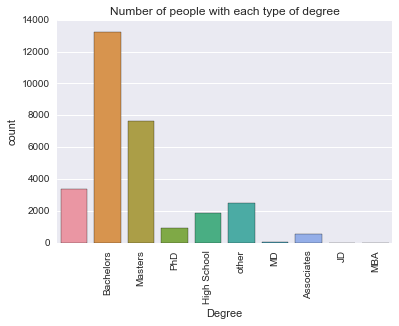

In [499]:
g = sns.countplot("ed_degree_clean", data = education)
plt.xticks(rotation=90)
g.set(xlabel = "Degree", title ="Number of people with each type of degree")

### Explore Exams

In [500]:
exams.head()

,ts_percentile,ts_duration,ts_pass,ts_name_raw,ts_score,ts_id,ts_when,ciphertext
3,93,12,1,U.S. English Basic Skills,4.5000000000000000,12874589,08/21/2015,~01d3ad50155896e4ae
4,83,13,1,Business Statistics Skills,4.1000000000000000,14413763,05/17/2016,~01d3ad50155896e4ae
5,73,10,1,Stock Trading,4.1000000000000000,14413667,05/16/2016,~01d3ad50155896e4ae
9,84,22,1,Knowledge of Microsoft Office Skills,3.0000000000000000,14382566,05/11/2016,~0199f1742b3c7202ba
10,76,47,1,MS SQL Server 2005,3.4000000000000000,14382494,05/10/2016,~0199f1742b3c7202ba


In [ ]:
#Raw test name

In [505]:
exams["ts_score"] = exams["ts_score"].apply(lambda x: float(x))

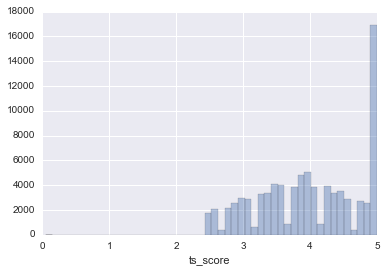

In [518]:
sns.distplot(exams["ts_score"], kde = False, bins = 50)

In [519]:
exams["ts_score"].value_counts().head()

5.00    16870
4.00     4615
3.90     3860
4.10     3749
3.75     3743
Name: ts_score, dtype: int64

A lot of people get a 5, and many people get around 4.0

In [523]:
print "There are %d different exams" %len(exams["ts_name_raw"].unique())

There are 503 different exams


In [682]:
exams["ts_name_raw"].value_counts().tail(20)

Knowledge of SAP ABAP                                           1
Paypal Integration for Mobile Skills                            1
Networking with Windows NT 4                                    1
Oracle Forms 9i                                                 1
Adobe Flash CS4 Test (Mac Version)                              1
Macromedia FreeHand MX                                          1
PHP Frontend Developer Test v3                                  1
Java Developer                                                  1
Knowledge of Skype Development                                  1
Facebook Open Platform Development                              1
DotNet 3.5 using VB                                             1
Quark XPress 8.0                                                1
Windows Networking Design Infrastructure                        1
Dreamweaver 8 Test (Mac Version)                                1
Networking Server 2003                                          1
Dimdim    

It looks like most of these are more basic and not data specific (Excel debatable)

In [525]:
print "%d people took at least one exam" %len(exams["ciphertext"].unique())

17840 people took at least one exam


In [530]:
num_exams_pp = exams[["ciphertext", "ts_name_raw"]].groupby("ciphertext").agg('count').reset_index()
print "People took an average number of %4.1f" %num_exams_pp["ts_name_raw"].mean() + " exams"

People took an average number of  4.8 exams


In [545]:
per_not_passed = float(len(exams[exams["ts_pass"] != "1"]))/len(exams)
print "Only %4.3f %% exams weren't passed" %per_not_passed

Only 0.003 % exams weren't passed


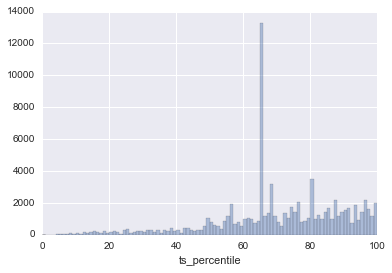

In [548]:
exams["ts_percentile"] = exams["ts_percentile"].apply(lambda x: float(x))
sns.distplot(exams["ts_percentile"], kde = False, bins = 100)

In [550]:
exams["ts_percentile"].value_counts().head(20)

65.0    13305
80.0     3486
68.0     3163
96.0     2195
87.0     2192
76.0     2029
56.0     1959
93.0     1893
74.0     1726
91.0     1675
85.0     1649
97.0     1621
90.0     1583
89.0     1456
95.0     1427
84.0     1413
75.0     1410
67.0     1368
72.0     1340
99.0     1336
Name: ts_percentile, dtype: int64

For some reason a lot of people get 65 percentile ...

### Examine Assignments

In [602]:
assignments.head()

,as_agency_name,as_ciphertext_opening_recno,as_financial_privacy,as_from_full,as_job_type,as_opening_title,as_rate,as_to,as_to_full,as_total_charge,as_total_hours,as_total_hours_precise,ciphertext
6,NaN,NaN,NaN,NaN,Fixed,Data Mining Research Project (1/3) Completed,$0.00,08/2016,08/12/2016,220,0.00,0,~01d3ad50155896e4ae
7,NaN,NaN,NaN,NaN,Fixed,STATA help- regression,$0.00,07/2016,07/25/2016,60,0.00,0,~01d3ad50155896e4ae
8,NaN,NaN,NaN,NaN,Fixed,Simple Python Programming,$0.00,07/2016,07/18/2016,50,0.00,0,~01d3ad50155896e4ae
9,NaN,NaN,NaN,NaN,Fixed,Forecasting - ARIMAX [R],None,07/2016,07/07/2016,None,0.00,0,~01d3ad50155896e4ae
10,NaN,NaN,NaN,NaN,Fixed,Statistical analysis for study with 116 partic...,None,06/2016,06/12/2016,None,0.00,0,~01d3ad50155896e4ae


In [930]:
fixed_with_payment = assignments[(pd.isnull(assignments["as_total_charge"]) == False) & (assignments["as_job_type"] == "Fixed")]
per_fixed_with_payment = float(len(fixed_with_payment))/len(assignments[assignments["as_job_type"] == "Fixed"])
per_fixed_with_payment = "%.2f" %per_fixed_with_payment
print "We have " + str(len(fixed_with_payment)) + " fixed assignmennts with payment information, which is " +  str(per_fixed_with_payment) + "% of all fixed assignments" 

We have 75111 fixed assignmennts with payment information, which is 0.59% of all fixed assignments


In [1037]:
hourly_with_payment = assignments[(pd.isnull(assignments["as_total_charge"]) == False) & (assignments["as_job_type"] == "Hourly")]
per_hourly_with_payment = float(len(hourly_with_payment))/len(assignments[assignments["as_job_type"] == "Hourly"])
per_hourly_with_payment = "%.2f" %per_hourly_with_payment
print "We have " + str(len(hourly_with_payment)) + " hourly assignmennts with payment information, which is " +  str(per_hourly_with_payment) + "% of all hourly assignments" 

We have 65196 hourly assignmennts with payment information, which is 0.57% of all hourly assignments


In [603]:
len(fixed_with_payment)

75111

In [607]:
fixed_with_payment["as_total_charge"].describe()

count    75111.000000
mean       150.383924
std        684.868773
min          1.000000
25%         15.000000
50%         40.000000
75%        111.000000
max      73877.030000
Name: as_total_charge, dtype: float64

In [1038]:
hourly_with_payment["as_total_charge"]  = hourly_with_payment["as_total_charge"].apply(lambda x: float(x))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [1039]:
hourly_with_payment["as_total_charge"].describe()

count     65196.000000
mean        831.083925
std        4242.404802
min           1.000000
25%          28.860000
50%          99.995000
75%         370.530000
max      229747.920000
Name: as_total_charge, dtype: float64

In [1040]:
hourly_with_payment["as_total_charge"].argmax()

110039

In [613]:
hourly_with_payment.loc[110039]

as_agency_name                                                              None
as_ciphertext_opening_recno                                                 None
as_financial_privacy                                                        None
as_from_full                                                                None
as_job_type                                                               Hourly
as_opening_title               Marketing Super Star for Microsoft IT Firm - C...
as_rate                                                                   $32.00
as_to                                                                    06/2016
as_to_full                                                            06/15/2016
as_total_charge                                                           229748
as_total_hours                                                              6996
as_total_hours_precise                                             6996.16666686
ciphertext                  

In [1041]:
hourly_with_payment_hours["as_total_hours"] = hourly_with_payment_hours["as_total_hours"].apply(lambda x: float(x))

In [1042]:
hourly_with_payment_hours = hourly_with_payment[hourly_with_payment["as_total_hours_precise"] != "0"]
hourly_with_payment_hours["as_total_hours_precise"] = hourly_with_payment_hours["as_total_hours_precise"].apply(lambda x: float(x))
hourly_with_payment_hours["as_total_charge"] = hourly_with_payment_hours["as_total_charge"].apply(lambda x: float(x))
hourly_with_payment_hours["real_rate"] = hourly_with_payment_hours["as_total_charge"]/hourly_with_payment_hours["as_total_hours_precise"]

In [1048]:
hourly_with_payment_hours["real_rate"].describe()

count    63832.000000
mean        12.592656
std         54.130395
min          0.010000
25%          3.330000
50%          5.560220
75%         15.000000
max       8530.020000
Name: real_rate, dtype: float64

In [663]:
hourly_with_payment_hours["real_rate"].argmax()

54358

In [664]:
hourly_with_payment_hours.iloc[54358]

as_agency_name                                                              None
as_ciphertext_opening_recno                                                 None
as_financial_privacy                                                        None
as_from_full                                                                None
as_job_type                                                               Hourly
as_opening_title               I need a developer to assist in repairing and ...
as_rate                                                                   $55.00
as_to                                                                    Present
as_to_full                                                               Present
as_total_charge                                                           256.67
as_total_hours                                                              4.67
as_total_hours_precise                                                   4.66667
ciphertext                  

In [667]:
hourly_less_200 = hourly_with_payment_hours[hourly_with_payment_hours["real_rate"] <= 200]

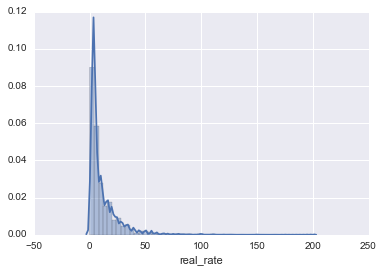

In [669]:
sns.distplot(hourly_less_200["real_rate"])

In [680]:
jobs_more_50 = hourly_with_payment_hours[hourly_with_payment_hours["real_rate"] >= 50]

In [681]:
len(jobs_more_50)

1919

### Explore titles

In [721]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [715]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=20,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(assignments["as_opening_title"])
tf_feature_names = tf_vectorizer.get_feature_names()

In [719]:
n_topics = 40
n_top_words = 20
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [723]:
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
lda.fit(tf)
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
excel vba file ppc link tool import spreadsheets master query formula group cleanup remove analyze sorting modifications match workbook rental
Topic #1:
create image images doc production food docs rate macros title comparison categorization tagging 300 vector old xls invoice gui slide
Topic #2:
developer business seo specialist php programmer senior css editor user medical map sem formatting joomla transfer implementation backend adding 15
Topic #3:
script facebook post store csv executive 100 manage results campaigns keywords fb 2008 groups verify calculation forums squarespace parts id
Topic #4:
database building com editing finding posting listing industry directory apps home b2b researching businesses australia contractor smm public 1000 infusionsoft
Topic #5:
amazon customer experience service account services keyword private price contract proofreading stock architect japanese templates shop retail forex crawler ninja
Topic #6:
software ui optimization address collect 

What are most popular words? 

In [726]:
word_appearance = zip(tf_vectorizer.get_feature_names(),
    np.asarray(tf.sum(axis=0)).ravel())

In [727]:
len(word_appearance)

3819

In [737]:
sorted_by_second = sorted(word_appearance, key=lambda tup: tup[1], reverse = True)

In [738]:
sorted_by_second[0:50]

[(u'data', 34386),
 (u'research', 17469),
 (u'entry', 16520),
 (u'excel', 15421),
 (u'web', 15045),
 (u'needed', 11294),
 (u'website', 10380),
 (u'need', 9366),
 (u'expert', 8227),
 (u'assistant', 6929),
 (u'email', 6552),
 (u'list', 6550),
 (u'google', 6218),
 (u'design', 5955),
 (u'project', 5938),
 (u'developer', 5314),
 (u'english', 4925),
 (u'help', 4851),
 (u'business', 4766),
 (u'writer', 4758),
 (u'create', 4625),
 (u'wordpress', 4592),
 (u'lead', 4366),
 (u'database', 4352),
 (u'researcher', 4219),
 (u'spreadsheet', 4126),
 (u'job', 4089),
 (u'contact', 4016),
 (u'analysis', 3863),
 (u'work', 3844),
 (u'site', 3759),
 (u'marketing', 3713),
 (u'product', 3647),
 (u'online', 3629),
 (u'content', 3614),
 (u'pdf', 3529),
 (u'app', 3505),
 (u'scraping', 3399),
 (u'development', 3342),
 (u'virtual', 3314),
 (u'article', 3167),
 (u'word', 3142),
 (u'simple', 3130),
 (u'generation', 3035),
 (u'specialist', 3008),
 (u'seo', 2951),
 (u'information', 2914),
 (u'new', 2890),
 (u'company',

### Create list of "data science" words. Jobs with any of these words will be considered data science projects

This was done with an iterative process: I first came up with my own list from domain knowledge, then I looked at titles of projects currently not classified as data science projects, used those to add more keywords, and kept going until I perceieved the classification of a random sample of titles to be correct.  

In [918]:
data_science_terms = ["(?i)data", "(?i)research", "(?i)entry", "(?i)excel", "(?i)web",
                     "(?i)developer", "(?i)database", "(?i)researcher", "(?i)spreadsheet", 
                     "(?i)scrap", "(?i)php", "(?i)python", "(?i)STATA", "(?i)SPSS", "(?i)SQL", 
                     "(?i)MATLAB", "(?i)study", "(?i)survey", "(?i)statis", "(?i)probability", 
                     "(?i)analy", "(?i)optimiz", "(?i)hadoop", "(?i)spark", "(?i)file", 
                     "(?i)machine", "(?i) R ", "(?i)science", "(?i)csv", "(?i)d3", "(?i)Visualiz", 
                     "(?i)mining", "(i?)java", "(?i)scrape", "(?i)quant", "(?i)model", "(?i)github",
                     "(?i)api ", "(?i)code", "(?i)program", "(?i)json", "(?i)automat", "(?i)devel", 
                     "(?i)search", "(?i)forecasting", "(?i)\[R\]", "(?i)calcul", "(?i)script", 
                     "(?i)processi", "(?i)classif", "(?i)simulat", "(?i)math", "(?i)algorit", 
                     "(?i)Probabil", "(?i)Predict"]

In [1069]:
# Make a regex that matches if any of our regexes match.
combined_data_science_terms = "(" + ")|(".join(data_science_terms) + ")"
data_science_job = assignments["as_opening_title"].apply(lambda x: 1 if re.search(combined_data_science_terms, x) else 0)
sum(data_science_job)

122359

In [922]:
assignments["ds_job"] = data_science_job
ds_jobs = assignments[assignments["ds_job"] == 1]

In [985]:
ds_hourly_with_payment = ds_jobs[(pd.isnull(ds_jobs["as_total_charge"]) == False) & (ds_jobs["as_job_type"] == "Hourly")]
ds_per_hourly_with_payment = float(len(ds_hourly_with_payment))/len(ds_jobs[ds_jobs["as_job_type"] == "Hourly"])
ds_per_hourly_with_payment = "%.2f" %ds_per_hourly_with_payment
print "We have " + str(len(ds_hourly_with_payment)) + " data science hourly assignmennts with payment information, which is " +  str(ds_per_hourly_with_payment) + "% of all data science hourly assignments" 

We have 36151 data science hourly assignmennts with payment information, which is 0.59% of all data science hourly assignments


In [935]:
ds_fixed_with_payment = ds_jobs[(pd.isnull(ds_jobs["as_total_charge"]) == False) & (ds_jobs["as_job_type"] == "Fixed")]
ds_per_fixed_with_payment = float(len(ds_fixed_with_payment))/len(ds_jobs[ds_jobs["as_job_type"] == "Fixed"])
ds_per_fixed_with_payment = "%.2f" %ds_per_fixed_with_payment
print "We have " + str(len(ds_fixed_with_payment)) + " fixed data science assignmennts with payment information, which is " +  str(ds_per_fixed_with_payment) + "% of all fixed data science assignments" 

We have 37579 fixed data science assignmennts with payment information, which is 0.62% of all fixed data science assignments


In [986]:
ds_fixed_with_payment["as_total_charge"] = ds_fixed_with_payment["as_total_charge"].apply(lambda x: float(x))
ds_hourly_with_payment["as_total_charge"] = ds_hourly_with_payment["as_total_charge"].apply(lambda x: float(x))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [987]:
ds_hourly_with_payment.head()

,as_agency_name,as_ciphertext_opening_recno,as_financial_privacy,as_from_full,as_job_type,as_opening_title,as_rate,as_to,as_to_full,as_total_charge,as_total_hours,as_total_hours_precise,ciphertext,ds_job
3,None,None,None,None,Hourly,Develop a model for providing a quantitative e...,$40.00,07/2016,07/07/2016,40.00,3.67,3.66666667,~01d3ad50155896e4ae,1
6,None,None,None,None,Hourly,"Data Entry using Google Maps, Google Streetvie...",$15.00,06/2016,06/13/2016,1284.17,92,91.5,~0199f1742b3c7202ba,1
7,,~015803731ec4eba7d3,0,06/27/2016,Hourly,Researcher - Phone & Internet,$8.00,08/2016,08/16/2016,36.00,4.50,4.5,~010ee721f96dbeb744,1
12,,~01a8d8d4a1ad0a014c,0,04/10/2014,Hourly,Business plan research | Must have experience ...,$4.44,01/2016,01/18/2016,46.62,10,10.49999999,~010ee721f96dbeb744,1
15,,~01e257d4d2891ac00c,0,07/10/2013,Hourly,Develop Marketing Material,$4.44,10/2014,10/07/2014,60.68,14,13.66666667,~010ee721f96dbeb744,1


In [997]:
ds_hourly_with_payment["as_total_hours_precise"] = ds_hourly_with_payment["as_total_hours_precise"].apply(lambda x: float(x))
ds_hourly_with_payment["as_total_charge"] = ds_hourly_with_payment["as_total_charge"].apply(lambda x: float(x))
ds_hourly_with_payment_hours = ds_hourly_with_payment[ds_hourly_with_payment["as_total_hours_precise"] != 0]
ds_hourly_with_payment_hours["real_rate"] = ds_hourly_with_payment_hours["as_total_charge"]/ds_hourly_with_payment_hours["as_total_hours_precise"]
ds_hourly_with_payment_hours["as_rate"] = ds_hourly_with_payment_hours["as_rate"].apply(lambda x: x.replace("$", ""))
ds_hourly_with_payment_hours["as_rate"] = ds_hourly_with_payment_hours["as_rate"].apply(lambda x: float(x))
ds_hourly_with_payment_hours["dif_rate"] = ds_hourly_with_payment_hours["real_rate"] - ds_hourly_with_payment_hours["as_rate"]
ds_hourly_with_payment_hours["dif_rate"] = ds_hourly_with_payment_hours["dif_rate"].apply(lambda x: float("{0:.2f}".format(x)))
ds_hourly_with_payment_hours["dif_rate"].describe()
# if real rate is positive, earned more than their listed hourly rate

count    35480.000000
mean         1.140543
std         32.919966
min       -200.000000
25%         -0.000000
50%          0.000000
75%          0.000000
max       3189.260000
Name: dif_rate, dtype: float64

In [999]:
ds_hourly_with_payment_hours["as_rate"].describe()

count    35480.000000
mean        11.025681
std         13.759844
min          0.010000
25%          3.330000
50%          5.560000
75%         15.000000
max        250.000000
Name: as_rate, dtype: float64

In [1000]:
ds_hourly_with_payment_hours["as_total_hours_precise"].describe()

count    35480.000000
mean       110.155238
std        458.984197
min          0.166667
25%          5.000000
50%         15.000000
75%         53.666667
max      16253.333333
Name: as_total_hours_precise, dtype: float64

In [1008]:
ds_hourly_with_payment_hours["as_to_full"] = ds_hourly_with_payment_hours["as_to_full"].apply(lambda x: pd.to_datetime(x, format='%m/%d/%Y') if x != "Present" else x)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [1017]:
# create dataframe with person id and number of assignments per person
count_of_assignments = ds_hourly_with_payment_hours[["ciphertext", "as_to"]]
count_of_assignments = count_of_assignments.groupby(["ciphertext"]).agg('count').reset_index()
count_of_assignments.columns = ["ciphertext", "number_of_ds_assignments"]
count_of_assignments["number_of_ds_assignments"].describe()
# most people have not done multiple data science assignments

count    8518.000000
mean        4.165297
std         6.415089
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       154.000000
Name: number_of_ds_assignments, dtype: float64

In [998]:
ds_hourly_with_payment_hours.head()

,as_agency_name,as_ciphertext_opening_recno,as_financial_privacy,as_from_full,as_job_type,as_opening_title,as_rate,as_to,as_to_full,as_total_charge,as_total_hours,as_total_hours_precise,ciphertext,ds_job,real_rate,dif_rate
3,None,None,None,None,Hourly,Develop a model for providing a quantitative e...,40.00,07/2016,07/07/2016,40.00,3.67,3.666667,~01d3ad50155896e4ae,1,10.909091,-29.09
6,None,None,None,None,Hourly,"Data Entry using Google Maps, Google Streetvie...",15.00,06/2016,06/13/2016,1284.17,92,91.500000,~0199f1742b3c7202ba,1,14.034645,-0.97
7,,~015803731ec4eba7d3,0,06/27/2016,Hourly,Researcher - Phone & Internet,8.00,08/2016,08/16/2016,36.00,4.50,4.500000,~010ee721f96dbeb744,1,8.000000,0.00
12,,~01a8d8d4a1ad0a014c,0,04/10/2014,Hourly,Business plan research | Must have experience ...,4.44,01/2016,01/18/2016,46.62,10,10.500000,~010ee721f96dbeb744,1,4.440000,0.00
15,,~01e257d4d2891ac00c,0,07/10/2013,Hourly,Develop Marketing Material,4.44,10/2014,10/07/2014,60.68,14,13.666667,~010ee721f96dbeb744,1,4.440000,-0.00


### Look at all education

In [941]:
with open("all_education.pkl", 'r') as picklefile: 
    all_education = pickle.load(picklefile)

In [942]:
first_matches1 = all_education["ed_degree"].apply(lambda x: 1 if re.match(list_of_regex[0][0], x) else 0)
for degree_tuple in list_of_regex[1:]:
    match_11 = all_education["ed_degree"].apply(lambda x: 1 if re.match(degree_tuple[0], x) else 0)
    first_matches1 = match_11 + first_matches1
# how many entries in first_matches are neither 0 nor 1?
mismatched_degrees1 = pd.concat([first_matches1, all_education["ed_degree"]], axis = 1)
mismatched_degrees1.columns = ["number_of_matches", "ed_degree"]
multiple_matches1 = mismatched_degrees1[(mismatched_degrees1["number_of_matches"] != 0) & (mismatched_degrees1["number_of_matches"] != 1)]
print "%d degrees matched more than one regex" %len(multiple_matches1)

0 degrees matched more than one regex


In [943]:
# Make a new clean_degree column
all_ed_degree_clean = all_education["ed_degree"]
for degree_tuple in list_of_regex:
    all_ed_degree_clean = all_ed_degree_clean.apply(lambda x: degree_tuple[1] if re.match(degree_tuple[0], x) else x)

In [944]:
# Check how many degrees don't fall into one of those categories
all_not_matching_degree = all_ed_degree_clean[(~all_ed_degree_clean.isin(list_of_clean_degrees)) & (all_ed_degree_clean != "")]
print "%d degrees are not one of the degrees" %len(all_not_matching_degree)

3263 degrees are not one of the degrees


In [945]:
all_not_matching_degree.value_counts().head()

Other                   2120
Licentiate degree        389
Computer Science          13
MCA                       11
Software Engineering       7
Name: ed_degree, dtype: int64

In [948]:
all_ed_degree_clean.head()

5             
6             
7             
8    Bachelors
9             
Name: ed_degree, dtype: object

In [949]:
# limit ed degree clean to other, blank, or one of the degrees
list_of_clean_degrees.append("other")
list_of_clean_degrees.append("")
all_ed_degree_clean = all_ed_degree_clean.apply(lambda x: x if x in list_of_clean_degrees else "other")

In [950]:
all_education["ed_degree_clean"] = all_ed_degree_clean

[<matplotlib.text.Text at 0x14dbc9f50>, <matplotlib.text.Text at 0x1591eea90>]

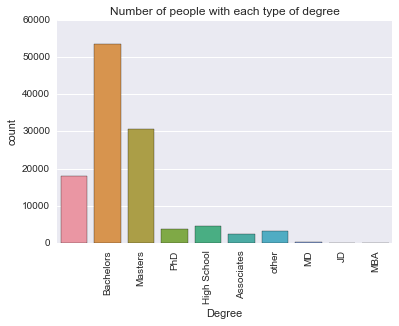

In [951]:
g = sns.countplot("ed_degree_clean", data = all_education)
plt.xticks(rotation=90)
g.set(xlabel = "Degree", title ="Number of people with each type of degree")

### Make a dataframe showing the person's highest degree

In [954]:
conversion_dict = {"": 1, "other": 2, "High School": 3, "Associates": 4, "Bachelors": 5, 
                  "Masters": 6, "JD": 7, "MBA": 8, "MD": 9, "PhD": 10}
all_education["degrees_ranked"] = all_education["ed_degree_clean"].apply(lambda x: conversion_dict[x])
highest_degree = all_education.groupby(['ciphertext'], sort=False)['degrees_ranked'].max()


In [1072]:
type(highest_degree)

pandas.core.series.Series

In [964]:
conversion_dict_reverse = {v: k for k, v in conversion_dict.items()}

In [966]:
highest_degree_df = pd.DataFrame(highest_degree).reset_index()
highest_degree_df["degrees_ranked"] = highest_degree_df["degrees_ranked"].apply(lambda x: conversion_dict_reverse[x])

In [1073]:
highest_degree_df.head()

,ciphertext,degrees_ranked
0,~01d3ad50155896e4ae,Bachelors
1,~01c11a0254dd09e3d4,Bachelors
2,~0146cf3cee361fe472,Bachelors
3,~0199f1742b3c7202ba,Bachelors
4,~010ee721f96dbeb744,Masters


In [1074]:
pd.DataFrame.to_csv(highest_degree_df, "highest_degree.csv")

In [1071]:
with open('highest_degree.pkl', 'w') as picklefile:
    pickle.dump(highest_degree_df, picklefile)

[<matplotlib.text.Text at 0x15da8f790>, <matplotlib.text.Text at 0x15da4e290>]

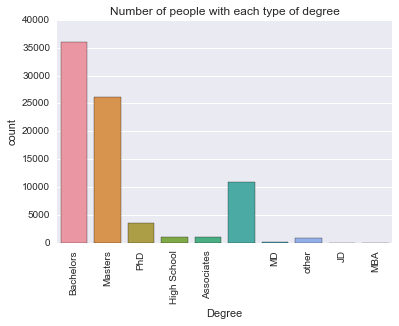

In [967]:
g = sns.countplot("degrees_ranked", data = highest_degree_df)
plt.xticks(rotation=90)
g.set(xlabel = "Degree", title ="Number of people with each type of degree")